In [1]:
import orjson
import matplotlib.pyplot as plt
from phd import viz
import numpy as np
from IPython.display import JSON

colors, swatches = viz.phd_style(jupyterStyle=True, grid=True)
%config InlineBackend.figure_formats = ['svg']

In [35]:
# channels_A = [35 + i  for i in range(8)]
# channels_B = [59 - i  for i in range(8)]
# data_names = [f"channel_visibility_{chA}_{chB}.json" for chA, chB in zip(channels_A, channels_B)]
# data_labels = [f"{chA}, {chB}" for chA, chB in zip(channels_A, channels_B)]
# data = []
# for name in data_names:
#     with open(f"../data/{name}", "rb") as f:
#         data.append(orjson.loads(f.read()))

In [36]:
with open("../data/channel_visibility_DENSITY_MATRIX_testing_SimpleSet.json", 'rb') as f:
    data = orjson.loads(f.read())

In [37]:
def output_vis(data_min, data_max, beginning_cut = 0):
    rate_min = np.array(data_min["results"]["counts_list"])/np.array(data_min["results"]["times_list"])
    rate_max = np.array(data_max["results"]["counts_list"])/np.array(data_max["results"]["times_list"])
    vis_arr = 1 - (rate_min[beginning_cut:]/rate_max[beginning_cut:])
    vis = np.average(vis_arr)
    vis_err = np.std(vis_arr)
    return vis, vis_err
    

In [38]:
def extract_rate(data_obj):
    rates = []
    for i, item in enumerate(data_obj["integration_results"]):
        coinc_times = np.array(item["full_coinc_1"])
        # if i == 0:
        #     print(item.keys())
        #     print(item["total_coincidences"])
        #     print(item["delta_time"])
        #     print(np.shape(coinc_times))
        delta_time = item["delta_time"]
        block_region_1 = (80,90)
        block_region_2 = (150, 160)
        coinc_times_filtered = filter_array_regions(coinc_times, block_region_1, block_region_2)
        # hist, bins = np.histogram(coinc_times_filtered, bins=300)
        # plt.plot(bins[:-1], hist/delta_time)
        # plt.yscale('log')
        # plt.grid(which='both')
        # plt.ylim(50,500)
        
        rates.append(len(coinc_times_filtered)/delta_time)
        
    rates = np.array(rates)
    rates = (rates/6)*16
    return np.average(rates), np.std(rates)

In [39]:
def filter_array_regions(array, region_1, region_2):
    filtered_array = array[(array <= region_1[0]) | (array >= region_1[1])]
    filtered_array = filtered_array[(filtered_array <= region_2[0]) | (filtered_array >= region_2[1])]
    return filtered_array

In [40]:
for i, item in enumerate(data["results"]):
    try:
        print(f"{i}: label: {item['label']}")
    except:
        pass

0: label: default_label
1: label: default_label
2: label: default_label
3: label: min scan 1
4: label: default_label
5: label: default_label
6: label: min integrate low power
7: label: default_label
8: label: default_label
9: label: min integrate high power
10: label: default_label
11: label: default_label
12: label: default_label
13: label: min scan 2
15: label: default_label
16: label: default_label
17: label: default_label
18: label: min-defined max integration low power
19: label: default_label
20: label: default_label
21: label: min-defined max integration high power
22: label: default_label
23: label: default_label
24: label: default_label
25: label: 90 degree integration low power
26: label: default_label
27: label: default_label
28: label: 90 degree integration high power
29: label: default_label
30: label: default_label
31: label: default_label
32: label: default_label
33: label: default_label
34: label: default_label
35: label: grad-defined max integration low power
36: label

In [44]:
for item in data["results"][28]["results"]:
    print(item["counts"])

5034
5053
5081
5148
5243


In [26]:
data["results"][30]

{'name': 'SetVoltage', 'label': 'default_label', 'voltage': 1.6}

In [6]:
high_power_vis = []
high_power_vis_err = []
high_power_rate = []

low_power_vis = []
low_power_vis_err = []
low_power_rate = []

rate_low_power = []
rate_low_power_err = []
rate_high_power = []
rate_high_power_err = []

for i, data_item in enumerate(data):
    min_low_power = data_item["results"][6]
    min_high_power = data_item["results"][9]
    max_low_power = data_item["results"][16]
    max_high_power = data_item["results"][19]
    
    vis, vis_err = output_vis(min_low_power, max_low_power, beginning_cut=1)
    low_power_vis.append(vis)
    low_power_vis_err.append(vis_err)
    
    vis, vis_err = output_vis(min_high_power, max_high_power, beginning_cut=1)
    high_power_vis.append(vis)
    high_power_vis_err.append(vis_err)
    
    rate, rate_err = extract_rate(min_low_power)
    rate_low_power.append(rate)
    rate_low_power_err.append(rate_err)
    
    rate, rate_err = extract_rate(min_high_power)
    rate_high_power.append(rate)
    rate_high_power_err.append(rate_err)
    

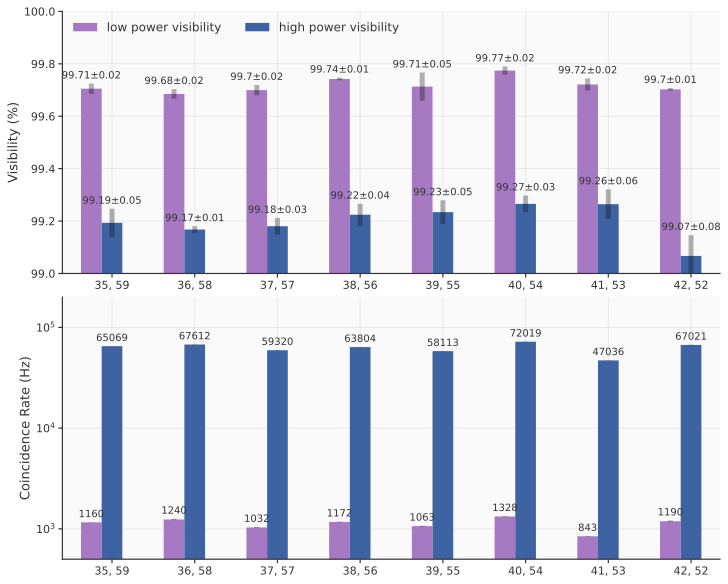

In [7]:
graph_data = {
    'low_power_vis': low_power_vis,
    'low_power_vis_err': low_power_vis_err,
    'high_power_vis': high_power_vis,
    'high_power_vis_err': high_power_vis_err,
    'rate_low_power': rate_low_power,
    'rate_low_power_err': rate_low_power_err,
    'rate_high_power': rate_high_power,
    'rate_high_power_err': rate_high_power_err,
}

x = np.arange(len(data_labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(2,1, layout='constrained', figsize=(10,8))
vis_ax = ax[0]
rate_ax = ax[1]
error_line = dict(lw=5, capsize=0, capthick=3, alpha=0.3, color="#00ff44")
    
rects = vis_ax.bar(x + 0, 
                   np.array(graph_data["low_power_vis"])*100, 
                   width, 
                   yerr = np.array(graph_data["low_power_vis_err"])*100,
                   error_kw=error_line,
                   label="low power visibility", 
                   color="#A779C3")
vis_ax.bar_label(rects, 
                 padding=3, 
                 labels=[f'{round(v,2)}±{round(e,2)}' for v, e in zip(np.array(graph_data["low_power_vis"])*100,np.array(graph_data["low_power_vis_err"])*100)])


rects = vis_ax.bar(x + width*1, 
                   np.array(graph_data["high_power_vis"])*100, 
                   width, 
                   yerr = np.array(graph_data["high_power_vis_err"])*100,
                   error_kw=error_line,
                   label="high power visibility", 
                   color="#3E63A3")
vis_ax.bar_label(rects, 
                 padding=3, 
                 labels=[f'{round(v,2)}±{round(e,2)}' for v, e in zip(np.array(graph_data["high_power_vis"])*100,np.array(graph_data["high_power_vis_err"])*100)])

# Add some text for labels, title and custom x-axis tick labels, etc.
vis_ax.set_ylabel('Visibility (%)')
# vis_ax.set_title('visibility by channel pairing')
vis_ax.set_xticks(x + width, data_labels)
legend = vis_ax.legend(loc='upper left', ncols=3, fancybox=False, frameon=False)
legend.get_frame().set_facecolor('none')
vis_ax.set_ylim(99, 100)


################

rects = rate_ax.bar(x + 0, 
                    graph_data["rate_low_power"], 
                    width, 
                    yerr = graph_data["rate_low_power_err"], 
                    error_kw=error_line,
                    label="rate low power", 
                    color="#A779C3")
rate_ax.bar_label(rects, 
                  padding=3, 
                  labels=[f'{round(v)}' for v, e in zip(graph_data["rate_low_power"],graph_data["rate_low_power_err"])])

rects = rate_ax.bar(x + width*1, 
                    graph_data["rate_high_power"], 
                    width, 
                    yerr = graph_data["rate_high_power_err"], 
                    error_kw=error_line,
                    label="high power vis", 
                    color="#3E63A3")
rate_ax.bar_label(rects, 
                  padding=3, 
                  labels=[f'{round(v)}' for v, e in zip(graph_data["rate_high_power"],graph_data["rate_high_power_err"])])
    

rate_ax.set_yscale('log')
rate_ax.set_ylim(500, 200000)
rate_ax.set_ylabel("Coincidence Rate (Hz)")
rate_ax.set_xticks(x + width, data_labels)
# vis_ax.legend(loc='upper left', ncols=3)

plt.show()